In [25]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pylab as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
import PIL
import PIL.Image

from sklearn.metrics import r2_score

In [26]:
image_dir = Path('.')
filepaths = pd.Series(list(image_dir.glob(r'*.jpg')), name='Filepath').astype(str)

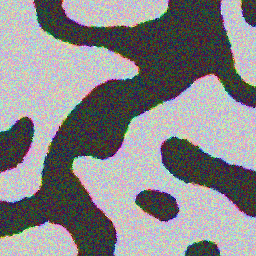

In [27]:
PIL.Image.open(str(filepaths[3]))

In [28]:
ku1, alphas, aexs, temp    = [],[],[],[]
for ii, value in enumerate(filepaths):
    if len(value.split('_')) == 4:
        ku1.append(value.split('_')[0])
        alphas.append(value.split('_')[1])
        aexs.append(value.split('_')[2])
        temp.append(value.split('_')[3].strip('.jpg'))

In [29]:
ku1    = pd.Series(ku1,    name='ku1').astype(int)
alphas = pd.Series(alphas, name='alphas').astype(float)
aexs   = pd.Series(aexs,   name='aexs').astype(float)
temp   = pd.Series(temp,   name='temp').astype(float)

In [30]:
images = pd.concat([filepaths, ku1, alphas, aexs, temp], axis=1).sample(frac=1.0, random_state=1).reset_index(drop=True)
sc     = StandardScaler()
normVal= sc.fit_transform(images.values[:,1:])
images['nku1'],images['nalphas'],images['naexs'],images['ntemp'] = normVal[:,0],normVal[:,1], normVal[:,2], normVal[:,3]

In [31]:
image_df = images.sample(960, random_state=1).reset_index(drop=True)

train_df, test_df = train_test_split(image_df, train_size=0.9, shuffle=True, random_state=1)

In [32]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
                        rescale=1./255,
                        validation_split=0.1
                    )

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
                        rescale=1./255
                    )

In [33]:
ot_cl =['nku1','nalphas','naexs','ntemp']
batchSize = 32
train_images = train_generator.flow_from_dataframe(
                    dataframe=train_df,
                    x_col='Filepath',
                    y_col=ot_cl,
                    target_size=(256, 256),
                    color_mode='rgb',
                    class_mode='raw',
                    batch_size=batchSize,
                    shuffle=True,
                    seed=42,
                    subset='training'
                )

val_images = train_generator.flow_from_dataframe(
                    dataframe=train_df,
                    x_col='Filepath',
                    y_col=ot_cl,
                    target_size=(256, 256),
                    color_mode='rgb',
                    class_mode='raw',
    
                    batch_size=batchSize,
                    shuffle=True,
                    seed=42,
                    subset='validation'
                )

test_images = test_generator.flow_from_dataframe(
                    dataframe=test_df,
                    x_col='Filepath',
                    y_col=ot_cl,
                    target_size=(256, 256),
                    color_mode='rgb',
                    class_mode='raw',
                    batch_size=batchSize,
                    shuffle=False
                )

Found 778 validated image filenames.
Found 86 validated image filenames.
Found 96 validated image filenames.


In [34]:
inputs = tf.keras.Input(shape=(256, 256,3))
x = tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu')(inputs)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.GlobalAvgPool2D()(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dense(64,  activation='relu')(x)
outputs = tf.keras.layers.Dense(len(ot_cl), activation='linear')(x)

In [35]:
model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 125, 125, 64)      18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 60, 60, 128)       73856     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 30, 30, 128)       0   

In [37]:
model.compile(optimizer='adam', loss='mse')

history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=10,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=10000,
            restore_best_weights=True
        )
    ]
)

Epoch 1/10
25/25 [==============================] - 57s 2s/step - loss: 0.5412 - val_loss: 0.5050
Epoch 2/10
25/25 [==============================] - 62s 3s/step - loss: 0.4386 - val_loss: 0.5055
Epoch 3/10
25/25 [==============================] - 52s 2s/step - loss: 0.4335 - val_loss: 0.4390
Epoch 4/10
25/25 [==============================] - 52s 2s/step - loss: 0.4151 - val_loss: 0.4145
Epoch 5/10
25/25 [==============================] - 53s 2s/step - loss: 0.4225 - val_loss: 0.4557
Epoch 6/10
25/25 [==============================] - 51s 2s/step - loss: 0.4467 - val_loss: 0.5331
Epoch 7/10
25/25 [==============================] - 53s 2s/step - loss: 0.4705 - val_loss: 0.4762
Epoch 8/10
25/25 [==============================] - 59s 2s/step - loss: 0.4240 - val_loss: 0.4433
Epoch 9/10
25/25 [==============================] - 62s 3s/step - loss: 0.4044 - val_loss: 0.3853
Epoch 10/10
25/25 [==============================] - 54s 2s/step - loss: 0.3792 - val_loss: 0.3939


In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [60]:
predicted_values = np.squeeze(model.predict(single_images))
true_values = single_images.labels

rmse = np.sqrt(model.evaluate(test_images, verbose=0))
print("Test RMSE     : {:.5f}".format(rmse))

r2 = r2_score(true_values, predicted_values)
print("Test R^2 Score: {:.5f}".format(r2))

Test RMSE     : 0.63582


ValueError: Found input variables with inconsistent numbers of samples: [1, 4]

In [16]:
1-rmse/(max(image_df.values[:,5:].flatten())-min(image_df.values[:,5:].flatten()))

0.9219242407215354

In [30]:
def display_learning_curves(history):
    fig, (ax1) = plt.subplots(1, 1, figsize=(10, 8))

    ax1.plot(history.history["loss"])
    ax1.plot(history.history["val_loss"])
    ax1.legend(["train", "test"], loc="upper right")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    fig.savefig('Learning_curve.png')

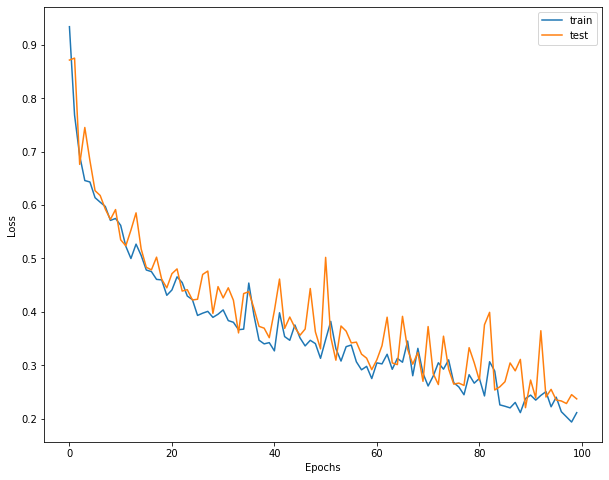

In [31]:
display_learning_curves(history)

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
Total params: 1,792
Trainable params: 1,792
Non-trainable params: 0
_________________________________________________________________


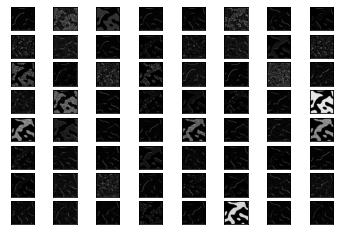

In [65]:
# plot feature map of first conv layer for given image
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import Model
from matplotlib import pyplot
from numpy import expand_dims
# load the model
model = VGG16()
# redefine model to output right after the first hidden layer
model = Model(inputs=model.inputs, outputs=model.layers[1].output)
model.summary()
# load the image with the required shape
img = load_img(filepaths[3], target_size=(224, 224))
# convert the image to an array
img = img_to_array(img)
# expand dimensions so that it represents a single 'sample'
img = expand_dims(img, axis=0)
# prepare the image (e.g. scale pixel values for the vgg)
img = preprocess_input(img)
# get feature map for first hidden layer
feature_maps = model.predict(img)
# plot all 64 maps in an 8x8 squares
square = 8
ix = 1
for _ in range(square):
    for _ in range(square):
        # specify subplot and turn of axis
        ax = pyplot.subplot(square, square, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        # plot filter channel in grayscale
        pyplot.imshow(feature_maps[0, :, :, ix-1], cmap='gray')
        ix += 1
# show the figure
pyplot.savefig('filters.png',dpi=500)
pyplot.show()

In [67]:
filepaths[3]

'10000000_0.85_1.03e-10_325.jpg'